In [6]:
#Imports
# import matplotlib.pyplot as plt
# from matplotlib import gridspec
# import tensorflow as tf 
# from tensorflow.keras.preprocessing import image_dataset_from_directory
# import numpy as np
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
print(tf.__version__)


2.6.0


My First Visual Studio Code, Tensorflow, & Jupyter Notebook Project

Code copied from https://www.kaggle.com/ryanholbrook/custom-convnets

In [7]:

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')



# Load training and validation sets
ds_train_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


Load Pretrained Base

In [8]:
pretrained_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=[128,128,3],
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
pretrained_base.trainable = False

Attach Head

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

Train

In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=1,
)

Epoch 1/30
80/80 [==============================] - 483s 6s/step - loss: 0.4753 - binary_accuracy: 0.7727 - val_loss: 0.3734 - val_binary_accuracy: 0.8388
Epoch 2/30
80/80 [==============================] - 383s 5s/step - loss: 0.3473 - binary_accuracy: 0.8526 - val_loss: 0.3396 - val_binary_accuracy: 0.8557
Epoch 3/30
80/80 [==============================] - 347s 4s/step - loss: 0.2982 - binary_accuracy: 0.8802 - val_loss: 0.3265 - val_binary_accuracy: 0.8626
Epoch 4/30
80/80 [==============================] - 353s 4s/step - loss: 0.2643 - binary_accuracy: 0.8974 - val_loss: 0.3210 - val_binary_accuracy: 0.8662
Epoch 5/30
80/80 [==============================] - 366s 5s/step - loss: 0.2381 - binary_accuracy: 0.9103 - val_loss: 0.3176 - val_binary_accuracy: 0.8658
Epoch 6/30
80/80 [==============================] - 369s 5s/step - loss: 0.2167 - binary_accuracy: 0.9226 - val_loss: 0.3139 - val_binary_accuracy: 0.8683
Epoch 7/30
80/80 [==============================] - 345s 4s/step - los

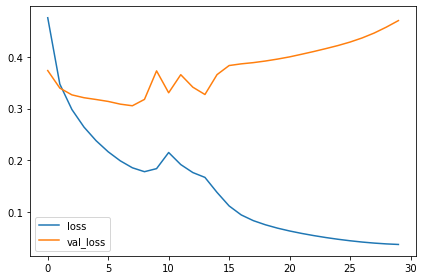

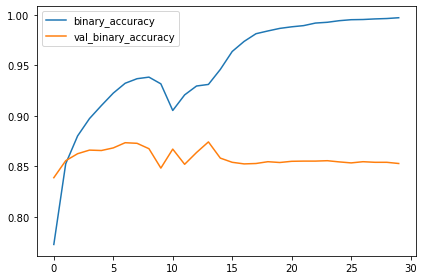

In [11]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
